<a href="https://colab.research.google.com/github/johnjkiran/TSAI/blob/master/S8/S8Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from __future__ import print_function
import torch.nn.functional as F
from torchvision import datasets, transforms

In [3]:
from os.path import join
from google.colab import drive
ROOT = "/content/drive"
drive.mount(ROOT)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from importlib.machinery import SourceFileLoader
config = SourceFileLoader('config',join('/content/drive/My Drive/Colab Notebooks/S8','config.py')).load_module()
from config import ModelConfig

In [5]:
# View model config
args = ModelConfig()
args.print_config()

print()
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

Model Parameters:
{ 'batch_size_cpu': 64,
  'batch_size_cuda': 64,
  'dropout_value': 0.15,
  'epochs': 50,
  'num_workers': 4,
  'seed': 1}

CUDA Available? True


In [0]:
utils = SourceFileLoader('utils',join('/content/drive/My Drive/Colab Notebooks/S8','utils.py')).load_module()
from utils import *

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
 bird horse   car   car


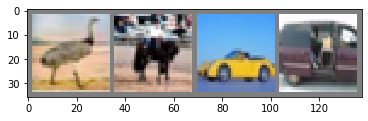

In [8]:
cifar_file = SourceFileLoader('cifar_file',join('/content/drive/My Drive/Colab Notebooks/S8','cifar_file.py')).load_module()
from cifar_file import DataEngine
data = DataEngine(args)
# get some random training images
dataiter = iter(data.train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%5s' % data.classes[labels[j]] for j in range(4)))


In [14]:
model = SourceFileLoader('model',join('/content/drive/My Drive/Colab Notebooks/S8','model.py')).load_module()
from model import *
device = which_device()
net = ResNet18()
model = net.to(device)
show_model_summary(model, device, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [0]:
train = SourceFileLoader('train',join('/content/drive/My Drive/Colab Notebooks/S8','train.py')).load_module()
from train import train
test = SourceFileLoader('test',join('/content/drive/My Drive/Colab Notebooks/S8','test.py')).load_module()
from test import test

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)

def run():
  test_losses = []
  test_accs = []
  misclassified_imgs = []
  for epoch in range(args.epochs):
      print("EPOCH:", epoch+1)
      train(model, device, data.train_loader, criterion, optimizer, epoch)
      test(model, device, data.test_loader, criterion, data.classes, test_losses, test_accs, misclassified_imgs, epoch==args.epochs-1)
  return test_losses, test_accs, misclassified_imgs

# train and test the model
test_losses, test_accs, misclassified_imgs = run()

  0%|          | 0/782 [00:00<?, ?it/s]

EPOCH: 1


Loss=1.1138094663619995 Batch_id=781 Accuracy=50.25: 100%|██████████| 782/782 [00:59<00:00, 13.07it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0164, Accuracy: 6168/10000 (61.68%)

EPOCH: 2


Loss=0.8232303857803345 Batch_id=781 Accuracy=68.52: 100%|██████████| 782/782 [01:00<00:00, 12.85it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0140, Accuracy: 6805/10000 (68.05%)

EPOCH: 3


Loss=0.6060267686843872 Batch_id=781 Accuracy=75.60: 100%|██████████| 782/782 [01:00<00:00, 12.97it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0151, Accuracy: 6791/10000 (67.91%)

EPOCH: 4


Loss=0.3506786823272705 Batch_id=781 Accuracy=80.52: 100%|██████████| 782/782 [01:00<00:00, 12.85it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0098, Accuracy: 7804/10000 (78.04%)

EPOCH: 5


Loss=0.3742448091506958 Batch_id=781 Accuracy=84.27: 100%|██████████| 782/782 [01:01<00:00, 12.75it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0119, Accuracy: 7486/10000 (74.86%)

EPOCH: 6


Loss=0.6026022434234619 Batch_id=781 Accuracy=86.87: 100%|██████████| 782/782 [01:01<00:00, 12.80it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0116, Accuracy: 7596/10000 (75.96%)

EPOCH: 7


Loss=0.30536848306655884 Batch_id=781 Accuracy=89.33: 100%|██████████| 782/782 [01:01<00:00, 12.74it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0094, Accuracy: 8003/10000 (80.03%)

EPOCH: 8


Loss=0.6367437839508057 Batch_id=781 Accuracy=91.27: 100%|██████████| 782/782 [01:01<00:00, 12.81it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0106, Accuracy: 7910/10000 (79.10%)

EPOCH: 9


Loss=0.2993769943714142 Batch_id=781 Accuracy=92.96: 100%|██████████| 782/782 [01:01<00:00, 12.74it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0096, Accuracy: 8050/10000 (80.50%)

EPOCH: 10


Loss=0.12560389935970306 Batch_id=781 Accuracy=94.00: 100%|██████████| 782/782 [01:01<00:00, 12.73it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0094, Accuracy: 8149/10000 (81.49%)

EPOCH: 11


Loss=0.3138888478279114 Batch_id=781 Accuracy=95.25: 100%|██████████| 782/782 [01:01<00:00, 12.77it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0107, Accuracy: 8033/10000 (80.33%)

EPOCH: 12


Loss=0.06051832437515259 Batch_id=781 Accuracy=95.80: 100%|██████████| 782/782 [01:00<00:00, 12.82it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0093, Accuracy: 8209/10000 (82.09%)

EPOCH: 13


Loss=0.21468916535377502 Batch_id=781 Accuracy=96.43: 100%|██████████| 782/782 [01:01<00:00, 12.81it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0108, Accuracy: 8124/10000 (81.24%)

EPOCH: 14


Loss=0.28549593687057495 Batch_id=781 Accuracy=96.96: 100%|██████████| 782/782 [01:00<00:00, 12.84it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0097, Accuracy: 8272/10000 (82.72%)

EPOCH: 15


Loss=0.2353985607624054 Batch_id=781 Accuracy=97.59: 100%|██████████| 782/782 [01:01<00:00, 12.77it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0110, Accuracy: 8201/10000 (82.01%)

EPOCH: 16


Loss=0.1274351328611374 Batch_id=781 Accuracy=98.14: 100%|██████████| 782/782 [01:01<00:00, 12.76it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0099, Accuracy: 8302/10000 (83.02%)

EPOCH: 17


Loss=0.3121718764305115 Batch_id=781 Accuracy=98.33: 100%|██████████| 782/782 [01:00<00:00, 12.84it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0098, Accuracy: 8317/10000 (83.17%)

EPOCH: 18


Loss=0.011758774518966675 Batch_id=781 Accuracy=98.61: 100%|██████████| 782/782 [01:01<00:00, 12.70it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0095, Accuracy: 8402/10000 (84.02%)

EPOCH: 19


Loss=0.052595511078834534 Batch_id=781 Accuracy=98.99: 100%|██████████| 782/782 [01:01<00:00, 12.72it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0103, Accuracy: 8337/10000 (83.37%)

EPOCH: 20


Loss=0.13800477981567383 Batch_id=781 Accuracy=99.13: 100%|██████████| 782/782 [01:01<00:00, 12.72it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0103, Accuracy: 8335/10000 (83.35%)

EPOCH: 21


Loss=0.0022935867309570312 Batch_id=781 Accuracy=98.83: 100%|██████████| 782/782 [01:00<00:00, 12.86it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0100, Accuracy: 8362/10000 (83.62%)

EPOCH: 22


Loss=0.011028677225112915 Batch_id=781 Accuracy=99.26: 100%|██████████| 782/782 [01:01<00:00, 12.76it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0104, Accuracy: 8324/10000 (83.24%)

EPOCH: 23


Loss=0.008450299501419067 Batch_id=781 Accuracy=99.32: 100%|██████████| 782/782 [01:01<00:00, 12.77it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0107, Accuracy: 8295/10000 (82.95%)

EPOCH: 24


Loss=0.1278105229139328 Batch_id=781 Accuracy=99.59: 100%|██████████| 782/782 [01:01<00:00, 12.74it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0098, Accuracy: 8444/10000 (84.44%)

EPOCH: 25


Loss=0.005521118640899658 Batch_id=781 Accuracy=99.61: 100%|██████████| 782/782 [01:00<00:00, 12.86it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 88 %
Accuracy of   car : 94 %
Accuracy of  bird : 73 %
Accuracy of   cat : 46 %
Accuracy of  deer : 86 %
Accuracy of   dog : 74 %
Accuracy of  frog : 92 %
Accuracy of horse : 86 %
Accuracy of  ship : 86 %
Accuracy of truck : 86 %

Test set: Average loss: 0.0092, Accuracy: 8520/10000 (85.20%)

EPOCH: 26


Loss=0.0007038116455078125 Batch_id=781 Accuracy=99.77: 100%|██████████| 782/782 [01:00<00:00, 12.91it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 84 %
Accuracy of   car : 82 %
Accuracy of  bird : 81 %
Accuracy of   cat : 66 %
Accuracy of  deer : 80 %
Accuracy of   dog : 76 %
Accuracy of  frog : 94 %
Accuracy of horse : 85 %
Accuracy of  ship : 97 %
Accuracy of truck : 95 %

Test set: Average loss: 0.0093, Accuracy: 8509/10000 (85.09%)

EPOCH: 27


Loss=0.02255919575691223 Batch_id=781 Accuracy=99.84: 100%|██████████| 782/782 [01:01<00:00, 12.74it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0097, Accuracy: 8462/10000 (84.62%)

EPOCH: 28


Loss=0.007519811391830444 Batch_id=781 Accuracy=99.90: 100%|██████████| 782/782 [01:01<00:00, 12.76it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0098, Accuracy: 8482/10000 (84.82%)

EPOCH: 29


Loss=0.05233544111251831 Batch_id=781 Accuracy=99.88: 100%|██████████| 782/782 [01:01<00:00, 12.72it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0096, Accuracy: 8493/10000 (84.93%)

EPOCH: 30


Loss=0.013588815927505493 Batch_id=781 Accuracy=99.91: 100%|██████████| 782/782 [01:00<00:00, 12.87it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 85 %
Accuracy of   car : 95 %
Accuracy of  bird : 72 %
Accuracy of   cat : 75 %
Accuracy of  deer : 83 %
Accuracy of   dog : 83 %
Accuracy of  frog : 88 %
Accuracy of horse : 91 %
Accuracy of  ship : 93 %
Accuracy of truck : 87 %

Test set: Average loss: 0.0094, Accuracy: 8572/10000 (85.72%)

EPOCH: 31


Loss=0.0018666386604309082 Batch_id=781 Accuracy=99.97: 100%|██████████| 782/782 [01:01<00:00, 12.78it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 84 %
Accuracy of   car : 96 %
Accuracy of  bird : 89 %
Accuracy of   cat : 67 %
Accuracy of  deer : 92 %
Accuracy of   dog : 67 %
Accuracy of  frog : 83 %
Accuracy of horse : 84 %
Accuracy of  ship : 95 %
Accuracy of truck : 93 %

Test set: Average loss: 0.0092, Accuracy: 8550/10000 (85.50%)

EPOCH: 32


Loss=0.023561179637908936 Batch_id=781 Accuracy=99.96: 100%|██████████| 782/782 [01:01<00:00, 12.80it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 83 %
Accuracy of   car : 92 %
Accuracy of  bird : 81 %
Accuracy of   cat : 69 %
Accuracy of  deer : 80 %
Accuracy of   dog : 80 %
Accuracy of  frog : 85 %
Accuracy of horse : 87 %
Accuracy of  ship : 96 %
Accuracy of truck : 86 %

Test set: Average loss: 0.0089, Accuracy: 8589/10000 (85.89%)

EPOCH: 33


Loss=0.023318320512771606 Batch_id=781 Accuracy=99.98: 100%|██████████| 782/782 [01:01<00:00, 12.75it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 96 %
Accuracy of   car : 89 %
Accuracy of  bird : 80 %
Accuracy of   cat : 66 %
Accuracy of  deer : 88 %
Accuracy of   dog : 70 %
Accuracy of  frog : 88 %
Accuracy of horse : 91 %
Accuracy of  ship : 87 %
Accuracy of truck : 91 %

Test set: Average loss: 0.0088, Accuracy: 8597/10000 (85.97%)

EPOCH: 34


Loss=0.008347094058990479 Batch_id=781 Accuracy=99.99: 100%|██████████| 782/782 [01:01<00:00, 12.70it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 94 %
Accuracy of   car : 91 %
Accuracy of  bird : 81 %
Accuracy of   cat : 60 %
Accuracy of  deer : 85 %
Accuracy of   dog : 80 %
Accuracy of  frog : 95 %
Accuracy of horse : 93 %
Accuracy of  ship : 95 %
Accuracy of truck : 89 %

Test set: Average loss: 0.0086, Accuracy: 8606/10000 (86.06%)

EPOCH: 35


Loss=0.007185757160186768 Batch_id=781 Accuracy=100.00: 100%|██████████| 782/782 [01:01<00:00, 12.81it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 87 %
Accuracy of   car : 91 %
Accuracy of  bird : 82 %
Accuracy of   cat : 78 %
Accuracy of  deer : 80 %
Accuracy of   dog : 77 %
Accuracy of  frog : 90 %
Accuracy of horse : 89 %
Accuracy of  ship : 91 %
Accuracy of truck : 96 %

Test set: Average loss: 0.0084, Accuracy: 8630/10000 (86.30%)

EPOCH: 36


Loss=0.0019434094429016113 Batch_id=781 Accuracy=100.00: 100%|██████████| 782/782 [01:01<00:00, 12.77it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 83 %
Accuracy of   car : 95 %
Accuracy of  bird : 77 %
Accuracy of   cat : 70 %
Accuracy of  deer : 87 %
Accuracy of   dog : 72 %
Accuracy of  frog : 91 %
Accuracy of horse : 98 %
Accuracy of  ship : 94 %
Accuracy of truck : 93 %

Test set: Average loss: 0.0084, Accuracy: 8629/10000 (86.29%)

EPOCH: 37


Loss=0.0018979310989379883 Batch_id=781 Accuracy=100.00: 100%|██████████| 782/782 [01:01<00:00, 12.75it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 88 %
Accuracy of   car : 91 %
Accuracy of  bird : 84 %
Accuracy of   cat : 70 %
Accuracy of  deer : 84 %
Accuracy of   dog : 80 %
Accuracy of  frog : 95 %
Accuracy of horse : 87 %
Accuracy of  ship : 90 %
Accuracy of truck : 86 %

Test set: Average loss: 0.0084, Accuracy: 8622/10000 (86.22%)

EPOCH: 38


Loss=0.0015754997730255127 Batch_id=781 Accuracy=100.00: 100%|██████████| 782/782 [01:01<00:00, 12.78it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 90 %
Accuracy of   car : 96 %
Accuracy of  bird : 76 %
Accuracy of   cat : 56 %
Accuracy of  deer : 82 %
Accuracy of   dog : 88 %
Accuracy of  frog : 97 %
Accuracy of horse : 91 %
Accuracy of  ship : 95 %
Accuracy of truck : 93 %

Test set: Average loss: 0.0085, Accuracy: 8629/10000 (86.29%)

EPOCH: 39


Loss=0.00023669004440307617 Batch_id=781 Accuracy=100.00: 100%|██████████| 782/782 [01:01<00:00, 12.77it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 82 %
Accuracy of   car : 96 %
Accuracy of  bird : 71 %
Accuracy of   cat : 68 %
Accuracy of  deer : 87 %
Accuracy of   dog : 85 %
Accuracy of  frog : 91 %
Accuracy of horse : 91 %
Accuracy of  ship : 88 %
Accuracy of truck : 96 %

Test set: Average loss: 0.0085, Accuracy: 8621/10000 (86.21%)

EPOCH: 40


Loss=0.0013068020343780518 Batch_id=781 Accuracy=100.00: 100%|██████████| 782/782 [01:01<00:00, 12.76it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 89 %
Accuracy of   car : 96 %
Accuracy of  bird : 80 %
Accuracy of   cat : 74 %
Accuracy of  deer : 88 %
Accuracy of   dog : 88 %
Accuracy of  frog : 94 %
Accuracy of horse : 90 %
Accuracy of  ship : 93 %
Accuracy of truck : 92 %

Test set: Average loss: 0.0083, Accuracy: 8617/10000 (86.17%)

EPOCH: 41


Loss=0.15791228413581848 Batch_id=781 Accuracy=100.00: 100%|██████████| 782/782 [01:00<00:00, 12.82it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 85 %
Accuracy of   car : 91 %
Accuracy of  bird : 79 %
Accuracy of   cat : 67 %
Accuracy of  deer : 88 %
Accuracy of   dog : 89 %
Accuracy of  frog : 90 %
Accuracy of horse : 94 %
Accuracy of  ship : 95 %
Accuracy of truck : 94 %

Test set: Average loss: 0.0083, Accuracy: 8628/10000 (86.28%)

EPOCH: 42


Loss=0.003990501165390015 Batch_id=781 Accuracy=99.98: 100%|██████████| 782/782 [01:01<00:00, 12.79it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 98 %
Accuracy of   car : 96 %
Accuracy of  bird : 72 %
Accuracy of   cat : 68 %
Accuracy of  deer : 81 %
Accuracy of   dog : 78 %
Accuracy of  frog : 91 %
Accuracy of horse : 93 %
Accuracy of  ship : 94 %
Accuracy of truck : 88 %

Test set: Average loss: 0.0086, Accuracy: 8595/10000 (85.95%)

EPOCH: 43


Loss=0.008352100849151611 Batch_id=781 Accuracy=99.99: 100%|██████████| 782/782 [01:01<00:00, 12.70it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 89 %
Accuracy of   car : 93 %
Accuracy of  bird : 78 %
Accuracy of   cat : 59 %
Accuracy of  deer : 84 %
Accuracy of   dog : 77 %
Accuracy of  frog : 91 %
Accuracy of horse : 95 %
Accuracy of  ship : 96 %
Accuracy of truck : 92 %

Test set: Average loss: 0.0082, Accuracy: 8615/10000 (86.15%)

EPOCH: 44


Loss=0.00272446870803833 Batch_id=781 Accuracy=100.00: 100%|██████████| 782/782 [01:01<00:00, 12.73it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 83 %
Accuracy of   car : 90 %
Accuracy of  bird : 78 %
Accuracy of   cat : 71 %
Accuracy of  deer : 85 %
Accuracy of   dog : 84 %
Accuracy of  frog : 87 %
Accuracy of horse : 95 %
Accuracy of  ship : 90 %
Accuracy of truck : 93 %

Test set: Average loss: 0.0083, Accuracy: 8621/10000 (86.21%)

EPOCH: 45


Loss=0.003965228796005249 Batch_id=781 Accuracy=100.00: 100%|██████████| 782/782 [01:01<00:00, 12.76it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 88 %
Accuracy of   car : 96 %
Accuracy of  bird : 77 %
Accuracy of   cat : 63 %
Accuracy of  deer : 88 %
Accuracy of   dog : 70 %
Accuracy of  frog : 90 %
Accuracy of horse : 95 %
Accuracy of  ship : 91 %
Accuracy of truck : 96 %

Test set: Average loss: 0.0083, Accuracy: 8618/10000 (86.18%)

EPOCH: 46


Loss=0.010823220014572144 Batch_id=781 Accuracy=100.00: 100%|██████████| 782/782 [01:01<00:00, 12.74it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 94 %
Accuracy of   car : 97 %
Accuracy of  bird : 78 %
Accuracy of   cat : 66 %
Accuracy of  deer : 81 %
Accuracy of   dog : 81 %
Accuracy of  frog : 83 %
Accuracy of horse : 94 %
Accuracy of  ship : 88 %
Accuracy of truck : 90 %

Test set: Average loss: 0.0083, Accuracy: 8664/10000 (86.64%)

EPOCH: 47


Loss=0.001199573278427124 Batch_id=781 Accuracy=100.00: 100%|██████████| 782/782 [01:01<00:00, 12.77it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 86 %
Accuracy of   car : 95 %
Accuracy of  bird : 70 %
Accuracy of   cat : 65 %
Accuracy of  deer : 83 %
Accuracy of   dog : 79 %
Accuracy of  frog : 91 %
Accuracy of horse : 88 %
Accuracy of  ship : 95 %
Accuracy of truck : 90 %

Test set: Average loss: 0.0083, Accuracy: 8609/10000 (86.09%)

EPOCH: 48


Loss=0.0138663649559021 Batch_id=781 Accuracy=100.00: 100%|██████████| 782/782 [01:01<00:00, 12.81it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 92 %
Accuracy of   car : 94 %
Accuracy of  bird : 77 %
Accuracy of   cat : 64 %
Accuracy of  deer : 84 %
Accuracy of   dog : 82 %
Accuracy of  frog : 94 %
Accuracy of horse : 88 %
Accuracy of  ship : 93 %
Accuracy of truck : 91 %

Test set: Average loss: 0.0081, Accuracy: 8640/10000 (86.40%)

EPOCH: 49


Loss=0.026073932647705078 Batch_id=781 Accuracy=100.00: 100%|██████████| 782/782 [01:01<00:00, 12.73it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 85 %
Accuracy of   car : 95 %
Accuracy of  bird : 82 %
Accuracy of   cat : 73 %
Accuracy of  deer : 74 %
Accuracy of   dog : 78 %
Accuracy of  frog : 96 %
Accuracy of horse : 91 %
Accuracy of  ship : 94 %
Accuracy of truck : 96 %

Test set: Average loss: 0.0080, Accuracy: 8662/10000 (86.62%)

EPOCH: 50


Loss=0.003147423267364502 Batch_id=781 Accuracy=100.00: 100%|██████████| 782/782 [01:01<00:00, 12.72it/s]



Accuracy of plane : 94 %
Accuracy of   car : 91 %
Accuracy of  bird : 88 %
Accuracy of   cat : 63 %
Accuracy of  deer : 74 %
Accuracy of   dog : 70 %
Accuracy of  frog : 93 %
Accuracy of horse : 94 %
Accuracy of  ship : 91 %
Accuracy of truck : 93 %

Test set: Average loss: 0.0080, Accuracy: 8634/10000 (86.34%)

